In [0]:
### import all the libraries we will be using. We set seeds for reproducibility 

import os
os.environ['PYTHONHASHSEED'] = '0'

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import math, re, os

import numpy as np
import pandas as pd
import keras
from matplotlib import pyplot as plt
import tensorflow as tf, tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from sklearn import metrics
from sklearn.model_selection import train_test_split

from keras.layers import *
from keras import optimizers, regularizers
from keras.models import Sequential,Model, load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LambdaCallback
from keras import optimizers, regularizers
from classification_models.tfkeras import Classifiers
import efficientnet.tfkeras as efn
from tta_wrapper import tta_classification

img_width = 400
img_height = 400
IMAGE_SIZE = [img_width, img_height]

tf.set_random_seed(234)
np.random.seed(234)


config = tf.ConfigProto(allow_soft_placement=True, intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
config.gpu_options.allow_growth = True
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Using TensorFlow backend.


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7



## Config

In [0]:
AUTO = tf.data.experimental.AUTOTUNE

## Data access. Directory to the data. I moved all the images into a single folder called data. Please do the same and 
## dir_to_data should point to that location

dir_to_data = 'data'

# Configuration
EPOCHS = 100
BATCH_SIZE = 8

## Load label and paths

In [0]:
#load the train, test and submission csv file into a pandas dataframe

train = pd.read_csv('train.csv',dtype=str)
test = pd.read_csv('test.csv', dtype=str)
sub = pd.read_csv('sample_submission.csv')

# shuffle the train dataframe
train = train.sample(random_state=234,frac=1).reset_index(drop=True)



#load the image paths.
train_paths = train.image.map(lambda x: (os.path.join(dir_to_data, '{}'.format(x))))
test_paths = test.image.map(lambda x: (os.path.join('test/test/', '{}'.format(x))))

#make the labels categorical
labels = np.array(train['label'].astype('category').cat.codes)
labels = keras.utils.to_categorical(labels)
train_labels = labels

#divide the dataset into a train and validation set. 
train_paths, valid_paths, train_labels, valid_labels = train_test_split(
    train_paths, train_labels, test_size=0.1, random_state=46)

## Create Dataset objects

A `tf.data.Dataset` object is needed in order to run the model using tensorflow

In [0]:
def decode_image(filename, label=None, image_size=(img_width,img_height)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

### Augmentation

In [0]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

In [0]:
def transform(image,label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),label

#### Create a train, validation and test dataset using tf.dataset . We map the train dataset to the decode_image function and apply augmentation using the transform function. No augmentation on the validation and test dataset.

In [11]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(transform, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Modelling 
##### EfficientNet B4 was used as the base_model and was initiated with <a href ='http://arxiv.org/abs/1911.04252'>noisy_student</a> weight
##### Optimizer was Adam and the loss function was categorical cross_entropy 

In [13]:
model = tf.keras.Sequential([
        efn.EfficientNetB4(
        input_shape=(img_width, img_width, 3),
        weights='noisy-student',
        include_top=False),
        L.GlobalAveragePooling2D(),
        L.Dense(train_labels.shape[1], activation='softmax')
    ])
        
model.compile(optimizer=tf.keras.optimizers.Adam(lr=3e-3, epsilon=0.1,decay=1.15e-5),loss = 'categorical_crossentropy', metrics=['acc'])
model.summary()

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
71680000/71678424 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 13, 13, 1792)      17673816  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 5379      
Total params: 17,679,195
Trainable params: 17,553,995
Non-trainable params: 125,200
_________________________________________________________________


### Start training
##### The best model (lowest loss) was saved and training was terminated if there is no reduction in the loss function after 10 epochs.

In [14]:
STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE
valid_step  = valid_labels.shape[0] // BATCH_SIZE
filepath = 'EfficientNetB4.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, mode='min')
ronp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, mode='auto')
Es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
callbacks = [checkpoint,Es,ronp]


history = model.fit(
    train_dataset, 
    epochs=EPOCHS, 
    callbacks=callbacks,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_dataset,
    validation_steps=valid_step)

Train on 98 steps, validate on 11 steps
Epoch 1/100
98/98 [==============================] - 403s 4s/step - loss: 1.0512 - acc: 0.4171 - val_loss: 1.0567 - val_acc: 0.3864
Epoch 2/100
98/98 [==============================] - 169s 2s/step - loss: 0.8802 - acc: 0.5829 - val_loss: 0.9477 - val_acc: 0.5455
Epoch 3/100
98/98 [==============================] - 166s 2s/step - loss: 0.7465 - acc: 0.6658 - val_loss: 0.7423 - val_acc: 0.6477
Epoch 4/100
98/98 [==============================] - 169s 2s/step - loss: 0.6649 - acc: 0.7245 - val_loss: 0.5904 - val_acc: 0.7614
Epoch 5/100
98/98 [==============================] - 167s 2s/step - loss: 0.4670 - acc: 0.8227 - val_loss: 0.4163 - val_acc: 0.8295
Epoch 6/100
98/98 [==============================] - 170s 2s/step - loss: 0.4762 - acc: 0.8189 - val_loss: 0.3947 - val_acc: 0.8068
Epoch 7/100
98/98 [==============================] - 166s 2s/step - loss: 0.4246 - acc: 0.8316 - val_loss: 0.3000 - val_acc: 0.8523
Epoch 8/100
98/98 [=================

## Evaluation

In [0]:
def display_training_curves(training, validation, title, subplot):
    """
    Source: https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
    """
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

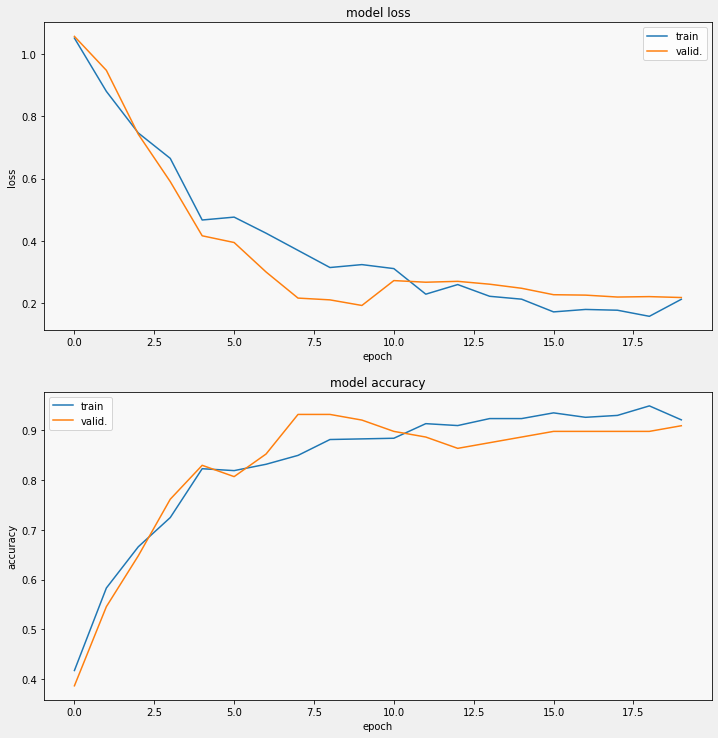

In [16]:
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'loss', 211)
display_training_curves(
    history.history['acc'], 
    history.history['val_acc'], 
    'accuracy', 212)

## Submission

#### We create the model without any weight. We load the saved weight into the model

In [0]:
model = tf.keras.Sequential([
        efn.EfficientNetB4(
        input_shape=(img_width, img_height, 3),
        weights=None,
        include_top=False),
        L.GlobalAveragePooling2D(),
        L.Dense(3, activation='softmax')])

model.load_weights(filepath)

In [0]:
### we get the ID of the images using the testpath and save it into a list. 

ID = []
for f in test_paths:
    f = f.rsplit('.')[0]
    f = f.rsplit('/')[-1]
    ID.append(f)

In [19]:
#predict with our model

predictions = model.predict(test_dataset, verbose=1)

77/77 [==============================] - 179s 2s/step


In [20]:
##save our prections into a dataframe and save as a csv

col = ['healthy_wheat','leaf_rust','stem_rust']
sub[col] = predictions
sub['ID'] = ID
sub.to_csv("EfficientNetB4.csv", index=False)
sub.head()

,ID,leaf_rust,stem_rust,healthy_wheat
0,WP4QZT,0.037212,0.956266,0.006522
1,BN5L96,0.012092,0.983677,0.004230
2,UC43IC,0.101518,0.897916,0.000567
3,AD54KD,0.272729,0.709935,0.017336
4,ROPN18,0.326420,0.646204,0.027376
